In [14]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [15]:

df = pd.read_csv('dataset/video_games_2016.csv')

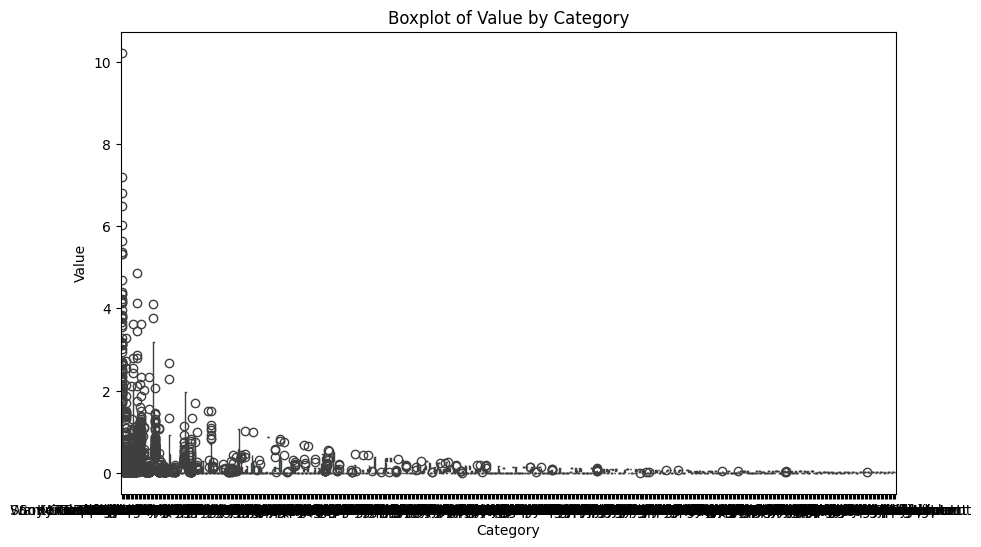

In [16]:

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the boxplot
# sns.boxplot(x='charger_type', y='charging_rate_kw', data=df)
sns.boxplot(x='Publisher', y='JP_Sales', data=df)

# Add title and labels
plt.title('Boxplot of Value by Category')
plt.xlabel('Category')
plt.ylabel('Value')

# Show the plot
plt.show()

In [17]:
df["Publisher"] = df["Publisher"].astype('category').cat.codes

X = np.array(df[[
    "JP_Sales",
    "Publisher"
]])

# Criando um vetor com as espécies de todos os registros de flores
y = np.array(df['Genre'])



In [18]:
from sklearn.model_selection import train_test_split

# Dividindo os conjuntos de treinamento e teste
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.3)

In [19]:
from sklearn import tree

modeloarvoredecisao = tree.DecisionTreeClassifier(criterion='entropy')     

In [20]:
modeloarvoredecisao.fit(X_treinamento, y_treinamento)

ValueError: Input contains NaN